#### データ取得元
https://www.data.jma.go.jp/risk/obsdl/index.php

/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_42803/3511610403.py:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df_temp = pd.concat([df_temp, df_empty]).reset_index(drop=True)
/var/folders/fw/ch0md4dj6x353_sr7k4k_f3r0000gq/T/ipykernel_42803/3511610403.py:56: UserWarning: Legend does not support handles for Series instances.
A proxy artist may be used instead.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#controlling-the-legend-entries
  ax.legend([df_temp['temperature']], [f'{this_year}'])


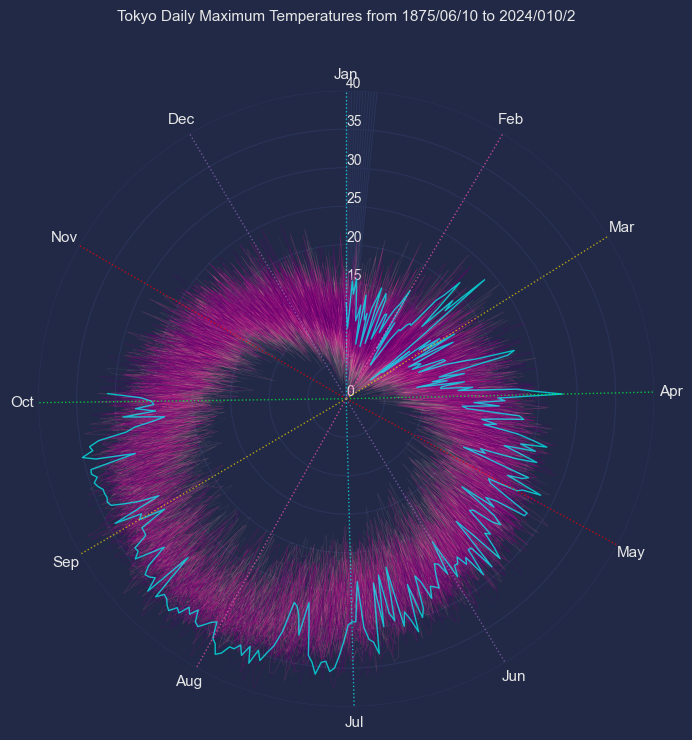

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.cm import get_cmap
from matplotlib.ticker import MaxNLocator
import mplcyberpunk

plt.style.use("cyberpunk")

df = pd.read_excel('/Users/Yusuke.Hayashi/Documents/temp_jupyter_notebook/tokyo-temp/tokyo-temp.xlsx')

df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month_day'] = df['date'].dt.strftime('%m-%d')
df = df.dropna()
df = df.drop_duplicates('date')
df = df.reset_index(drop=True)

cmap = get_cmap('RdPu')
years = np.arange(df['year'].min(), df['year'].max()+1)
month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
days_in_month = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
start_year = min(df['year'])
this_year = max(df['year'])
this_month = int(df['date'].dt.month[-1:].values)
this_day = int(df['date'].dt.day[-1:].values)

def plot_radar_chart(df):
    
    # プロットを初期化
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))

    for i, year in enumerate(years):
        df_temp = df[df['year'] == year]
        df_temp = df_temp[['year', 'month_day', 'temperature']]
        if year != this_year:
            angles = np.linspace(0, 2 * np.pi, len(df_temp), endpoint=False).tolist()
            df_temp = pd.concat([df_temp, df_temp.iloc[[0]]]).reset_index(drop=True)
            angles += angles[:1]
            year_color = cmap((year - years[0]) / (years[-1] - years[0]))
            ax.plot(angles, df_temp['temperature'], color=year_color, linewidth=0.3, alpha=0.5 * (year - years[0]) / (years[-1] - years[0]))
        else:
            column_names = df.columns
            new_df_length = 365 - len(df_temp)
            empty_data = {'year': [this_year] * new_df_length,
                          'month_day': df[df['year'] == (this_year - 1)]['month_day'].iloc[-new_df_length:],
                          'temperature': [pd.NA] * new_df_length}
            df_empty = pd.DataFrame(empty_data)
            df_temp = pd.concat([df_temp, df_empty]).reset_index(drop=True)
            angles = np.linspace(0, 2 * np.pi, len(df_temp), endpoint=False).tolist()
            df_temp = pd.concat([df_temp, df_temp.iloc[[0]]]).reset_index(drop=True)
            angles += angles[:1]
            year_color = 'cyan'
            ax.plot(angles, df_temp['temperature'], color=year_color, linewidth=1.0, alpha=0.7)
            ax.legend([df_temp['temperature']], [f'{this_year}'])
        
    # X軸（日付）のラベルを設定
    angles = (np.cumsum([0] + days_in_month[:-1]) / 365.0 * 2 * np.pi)
    # 月のラベルを追加
    
    for angle, month in zip(angles, range(1, 13)):
        ax.plot([angle, angle], [0, 40], linewidth=1, alpha=0.7, linestyle='dotted')
        ax.text(angle, ax.get_rmax() + 0.08, month_names[month-1], horizontalalignment='center', verticalalignment='center', size=11)

    # 各日付に合わせてグリッドラインを引く
    ax.set_theta_offset(np.pi / 2)
    ax.set_theta_direction(-1)
    ax.set_thetagrids(angles, labels=month_names, alpha=0.0, fontsize=0)
    ax.grid(True)

    # 動径方向のグリッドラインを引く
    tick_values = np.linspace(0, 40, 9) # -10度から40度まで11個の値
    tick_labels = [str(x) for x in range(0, 41, 5)] # 5度刻みでラベルを設定
    ax.set_rgrids(tick_values, labels=tick_labels, angle=0)
     
    # 円グラフの外観をカスタマイズ
    ax.spines['polar'].set_visible(True)
    ax.set_ylim(0, 40)
    plt.title(f'Tokyo Daily Maximum Temperatures from 1875/06/10 to {this_year}/0{this_month}/{this_day}', size=11, y=1.1)
    plt.show()

plot_radar_chart(df)

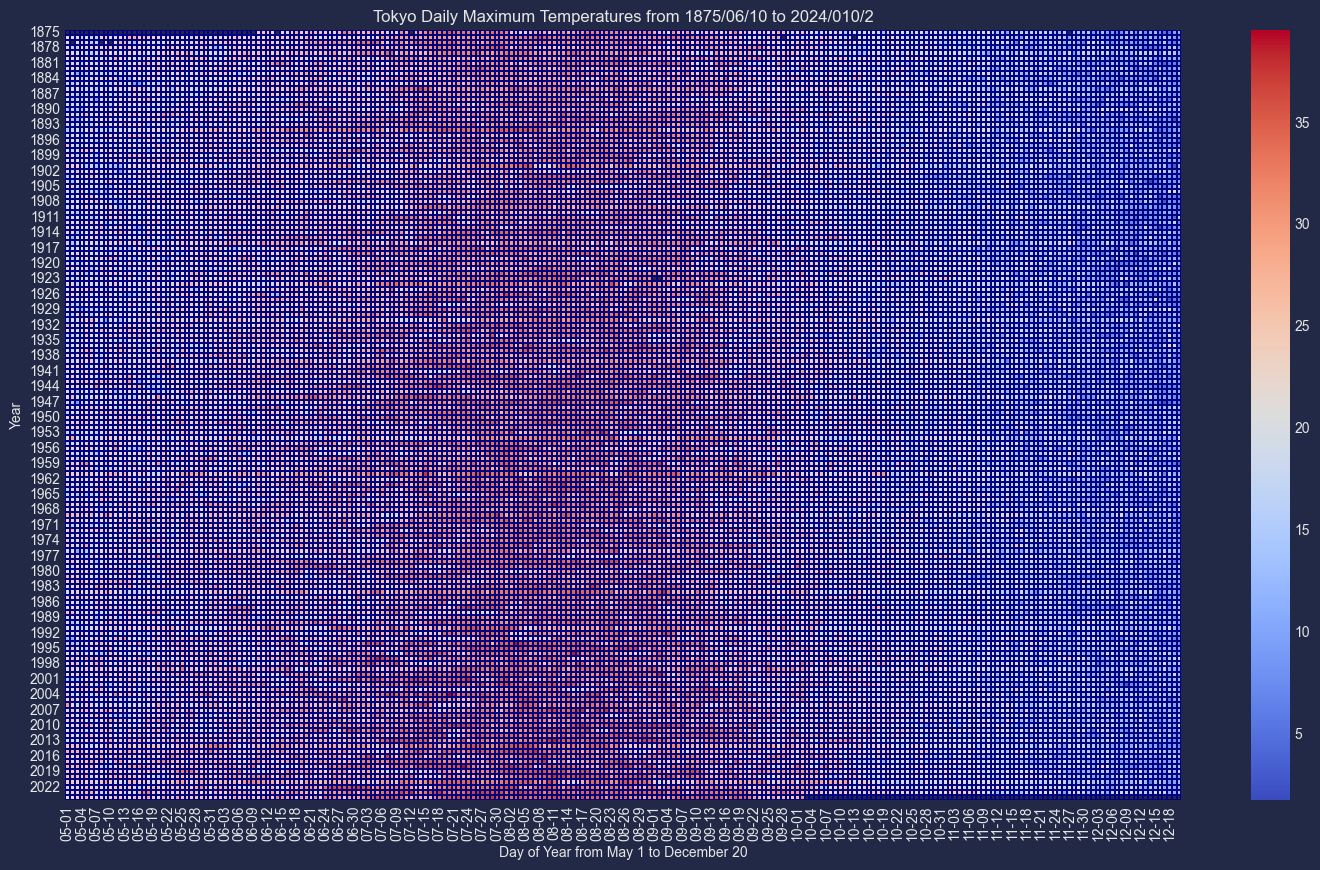

In [2]:
heatmap_data = df[('05-01' <= df['month_day']) & (df['month_day'] <= '12-20')]
heatmap_data = heatmap_data.pivot(index='year', columns='month_day', values='temperature')
heatmap_data.sort_index(inplace=True)

plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='coolwarm', linewidths=0.005, linecolor='navy', cbar=True)

plt.title(f'Tokyo Daily Maximum Temperatures from 1875/06/10 to {this_year}/0{this_month}/{this_day}')
plt.xlabel('Day of Year from May 1 to December 20')
plt.ylabel('Year')
plt.grid(False)
plt.show()

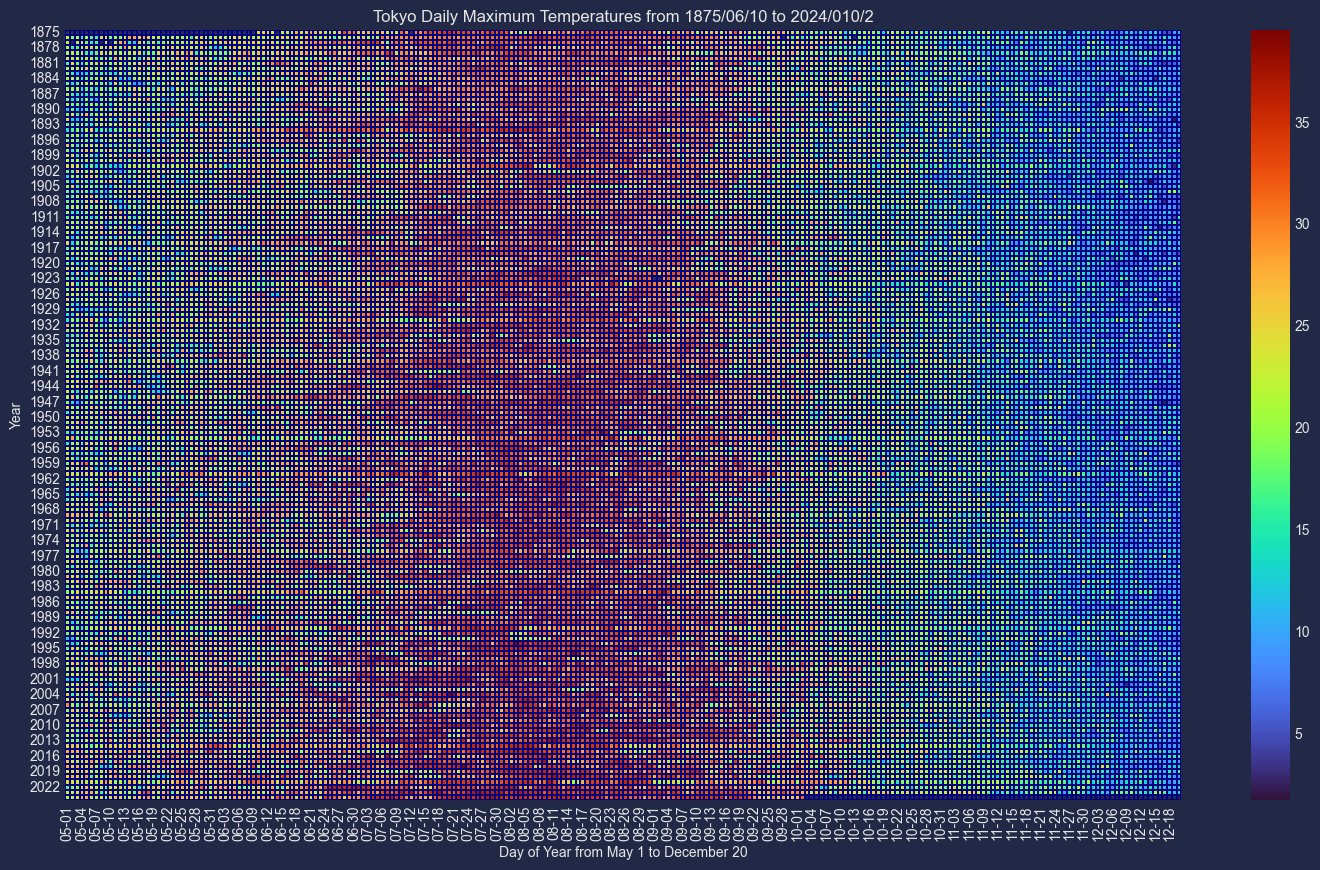

In [3]:
# 温度変化の離散化
num_bins = 8
temp_bins = np.linspace(df[('05-01' <= df['month_day']) & (df['month_day'] <= '12-20')]['temperature'].min(), df[('05-01' <= df['month_day']) & (df['month_day'] <= '12-20')]['temperature'].max(), num_bins)
df['digit_temperature'] = np.digitize(df['temperature'], temp_bins)

heatmap_data = df[('05-01' <= df['month_day']) & (df['month_day'] <= '12-20')]
heatmap_data = heatmap_data.pivot(index='year', columns='month_day', values='temperature')
heatmap_data.sort_index(inplace=True)

plt.figure(figsize=(18, 10))
sns.heatmap(heatmap_data, cmap='turbo', linewidths=0.005, linecolor='navy')

plt.title(f'Tokyo Daily Maximum Temperatures from 1875/06/10 to {this_year}/0{this_month}/{this_day}')
plt.xlabel('Day of Year from May 1 to December 20')
plt.ylabel('Year')
plt.grid(True)
plt.show()